# Glare Detection in photographs

This project was given to me as a preliminary to a job interview at Abyss solutions. I'll be attempting to train a machine learning classifier to detect glare in photographs, the final testing will be done by Abyss solutions so will not be included in this writeup.

For this project I'll be using the Python Pytorch library. Instructions for download can be found [here](https://pytorch.org/get-started/locally/).

In [1]:
# Importing necessary packages:

import numpy as np
from time import time
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim

from torchvision import datasets, transforms, models

# A few functions held in helper for the sake of space
import helper

In [2]:
# Loading in the data
data_dir = 'training_data'

# Convert to a torch tensor and normalise
transform  = transforms.Compose([     transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
dataset = datasets.ImageFolder(data_dir, transform=transform, target_transform = lambda x: (x+1) % 2)

# Un-normalise function for displaying the images
unorm = helper.UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

The transform above serves to convert the images to a Torch tensor object and to normalize the data as appropriate to the CNN we will be using.

Lets have a look at some of the images:

In [3]:
# Size of the images
dataset[0][0].shape

torch.Size([3, 600, 800])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


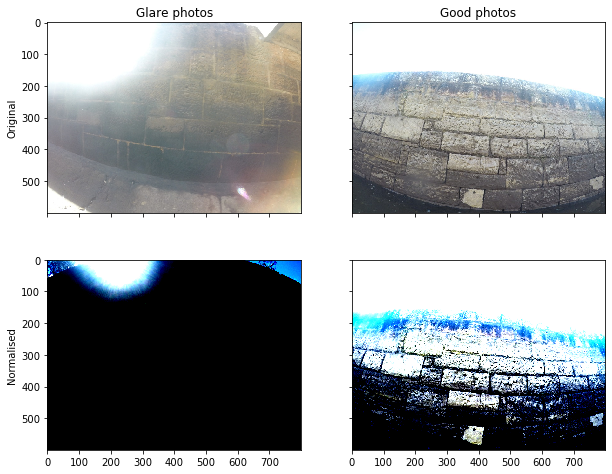

In [4]:
# Plotting some of the images
fig, axs = plt.subplots(2,2, figsize = (10,8), sharex = True, sharey = True)
axs[0,0].imshow(unorm(dataset[0][0]).numpy().transpose((1, 2, 0)))
axs[0,0].set_title('Glare photos')
axs[0,0].set(ylabel = 'Original')
axs[0,1].imshow(unorm(dataset[41][0]).numpy().transpose((1, 2, 0)))
axs[0,1].set_title('Good photos')
axs[1,0].imshow(dataset[1][0].numpy().transpose((1, 2, 0)))
axs[1,0].set(ylabel = 'Normalised')
axs[1,1].imshow(dataset[41][0].numpy().transpose((1, 2, 0)))

To us the photos with glare in are obvious, however this will be a challenge for any computer vision model as many of the good photos still contain glaringly bright areas.

The dataset also only contained 80 images, and scouring through the dataset I found some interesting anomalies:

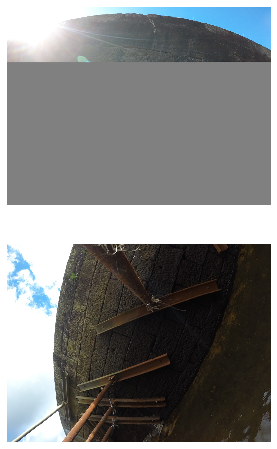

In [5]:
fig, axs = plt.subplots(2, figsize = (10,8))
axs[0].set_axis_off()
axs[1].set_axis_off()
axs[0].imshow(unorm(dataset[28][0]).numpy().transpose((1, 2, 0)))
axs[1].imshow(unorm(dataset[78][0]).numpy().transpose((1, 2, 0)))

The first has had a portion of the image corrupted and the second has been rotated a significant amount. Infact varying degrees of rotation wasn't uncommon across the training dataset.
I will want my model to be able to detect the glare regardless of these hinderences, given the small size of the dataset I'll aim to increase the size by duplicating some of the images with similar rotations and corruptions.

In [6]:
# Creating another dataset with data augmentation
torch.manual_seed(0)
augmentations = [transforms.RandomRotation(degrees = (45,100)), # add random rotation
                 transforms.Compose([transforms.ToTensor(),
                                     transforms.RandomErasing(p=1, value=(0.5020, 0.5020, 0.5020)), # erase to grey
                                     transforms.ToPILImage()])]

transform  = transforms.Compose([transforms.RandomChoice(augmentations),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406],
                                                      [0.229, 0.224, 0.225])])
dataset_augmented = datasets.ImageFolder(data_dir, transform=transform, target_transform = lambda x: (x+1) % 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


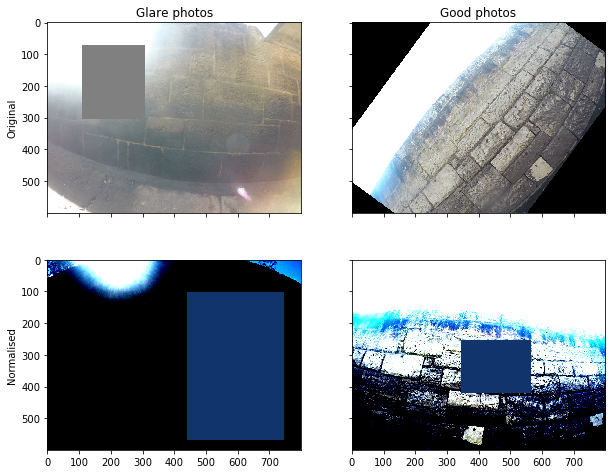

In [7]:
# Augmentation examples
fig, axs = plt.subplots(2,2, figsize = (10,8), sharex = True, sharey = True)
axs[0,0].imshow(unorm(dataset_augmented[0][0]).numpy().transpose((1, 2, 0)))
axs[0,0].set_title('Glare photos')
axs[0,0].set(ylabel = 'Original')
axs[0,1].imshow(unorm(dataset_augmented[41][0]).numpy().transpose((1, 2, 0)))
axs[0,1].set_title('Good photos')
axs[1,0].imshow(dataset_augmented[1][0].numpy().transpose((1, 2, 0)))
axs[1,0].set(ylabel = 'Normalised')
axs[1,1].imshow(dataset_augmented[41][0].numpy().transpose((1, 2, 0)))

In [8]:
# Increase dataset by 20 augmented photos
aug = torch.utils.data.Subset(dataset_augmented, indices = [i for i in range(10)] + [i + 40 for i in range(10)])
dataset_2 = torch.utils.data.ConcatDataset([dataset, aug])

# Split into training and testing datasets
train_data, validation_data = torch.utils.data.random_split(dataset_2, [70, 30])

# Create data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size = 10, shuffle = True)
validloader = torch.utils.data.DataLoader(validation_data, batch_size = 10, shuffle = True)

I'll be using a pretrained CNN model from the torchvision library help extract the image features. For this I've chosen to use the ResNet-50 model taken from [“Deep Residual Learning for Image Recognition”](https://arxiv.org/pdf/1512.03385.pdf). This CNN was trained on the extremely large [ImageNet](http://www.image-net.org/) database and managed to achieve a top-1 error of only 23.85%. 

Given the complexity of the model architecture I wont be training the CNN itself, rather I'll adjoin a neural network classifier to the outputted feature vector to train.

In [9]:
model = models.resnet34(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

From above we see that the ResNet-34 CNN has a final fully-connected neural network layer that gives a 1000 length vector output. I'll replace that with my own classifier to give a 2 dimensional vector output:

In [10]:
# Freeze CNN parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

# Define new neural network
from collections import OrderedDict
layers = OrderedDict([
                          ('fc1', nn.Linear(512,256)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(256,2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ])

classifier = nn.Sequential(layers)
    
# Replace final layers
model.fc = classifier

# Define optimiser and loss critera
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
criterion = nn.NLLLoss()

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

To speed up the training time the GPU can be used to run parallel operations. This is only possible if CUDA is avalible on your machine.

Below I will finally start training the model using backpropagation and gradient descent. After each epoch the model will be tested on the validation set to measure the loss (cross-entropy loss as chosen above). In order to prevent overfitting the model will not be saved if there is no decrease in the validation set loss, regardless of the training loss.

*Note this is the most computationally extensive part of the notebook and may take a long time to run.*

In [11]:
# number of epochs to train the model
n_epochs = 30
train_losses = []
valid_losses = []
valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    # Start time
    t0 = time()
    for data, target in trainloader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
    # Get training time
    t1 = time()
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in validloader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    # get validation time
    t2 = time()
    # calculate average losses
    train_loss = train_loss/len(trainloader.sampler)
    valid_loss = valid_loss/len(validloader.sampler)
    train_time = t1 - t0
    valid_time = t2 - t1
    
    train_losses += [train_loss]
    valid_losses += [valid_loss]
    # print training/validation statistics 
    print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f} \tTotal time: {train_time + valid_time:.1f}')
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
        torch.save({'layers': layers, 'state_dict': model.fc.state_dict()}, 'model_glare.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.234786 	Validation Loss: 1.029872 	Total time: 324.4
Validation loss decreased (inf --> 1.029872).  Saving model ...
Epoch: 2 	Training Loss: 0.705946 	Validation Loss: 0.632720 	Total time: 353.0
Validation loss decreased (1.029872 --> 0.632720).  Saving model ...
Epoch: 3 	Training Loss: 0.707821 	Validation Loss: 0.604221 	Total time: 380.4
Validation loss decreased (0.632720 --> 0.604221).  Saving model ...
Epoch: 4 	Training Loss: 0.596181 	Validation Loss: 0.572857 	Total time: 342.9
Validation loss decreased (0.604221 --> 0.572857).  Saving model ...
Epoch: 5 	Training Loss: 0.561253 	Validation Loss: 0.494848 	Total time: 452.6
Validation loss decreased (0.572857 --> 0.494848).  Saving model ...
Epoch: 6 	Training Loss: 0.512671 	Validation Loss: 0.451564 	Total time: 481.7
Validation loss decreased (0.494848 --> 0.451564).  Saving model ...
Epoch: 7 	Training Loss: 0.454621 	Validation Loss: 0.339841 	Total time: 445.3
Validation loss decreased (0.45

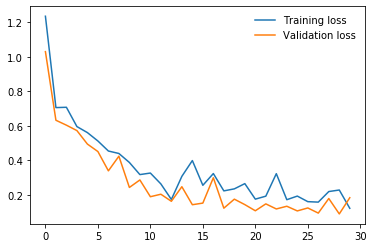

In [12]:
# Plot the losses
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

The 

In [16]:
# Loading saved model
load = torch.load('model_glare.pt')
model.fc.load_state_dict(load['state_dict'])

<All keys matched successfully>

Lets have a look at some of the misclassified images ...

In [17]:
# Get confusion matrix, false-positives, false-negatives low certainty images
conf, fp, fn, uncertain = helper.performance(model, validloader)

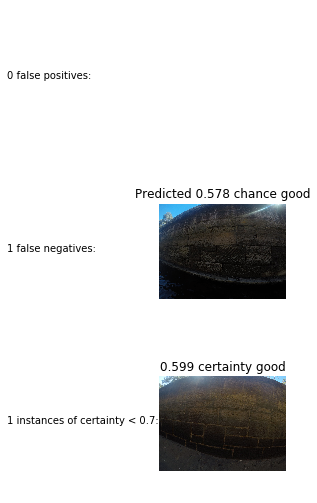

In [20]:
helper.display(fp, fn, uncertain)

In [22]:
# Get confusion matrix, false-positives, false-negatives low certainty images
conf, fp, fn, uncertain = helper.performance(model, trainloader)

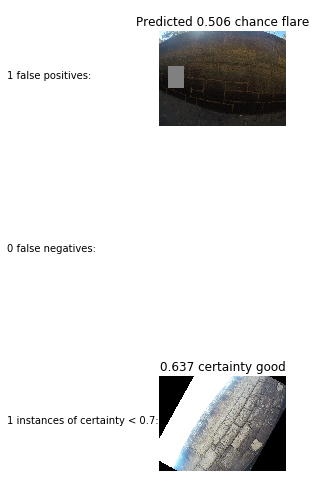

In [23]:
helper.display(fp, fn, uncertain)